In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib.dates import DayLocator, DateFormatter
import matplotlib.dates as mdates

%matplotlib widget

PCD_DIR = "res/point_clouds_meshed"
PCD_PATTERN = "sampled*.ply"
OUT_DIR = "res/volumes_variations"
DOD_DIR = "x"
TSTEP = 5
GRID_STEP = 0.3
TEMPERATURE_FILE = "res/temperature_data/temperature_zamboni.csv"
# SURF_VEL_FILE = "res/surface_velocities/TS_punto-fronte.txt"
SURF_VEL_FILE = "res/surface_velocities/TS_punto-corpo.txt"

icepy_dir = Path.cwd().parents[1]

# Paths
pcd_dir = icepy_dir / Path(PCD_DIR)
out_dir = icepy_dir / Path(OUT_DIR)
temp_path = icepy_dir / Path(TEMPERATURE_FILE)

# Output file
fout_name = (
    f"{PCD_PATTERN.split('*')[0]}_dir{DOD_DIR.upper()}_tstep{TSTEP}_grid{GRID_STEP}"
)
fout = out_dir / f"{fout_name}.csv"

# import matplotlib.dates as mdates
dateFmt = DateFormatter('%b')

# Read volume results from file
column_names = [
    "pcd0",
    "pcd1",
    "volume",
    "addedVolume",
    "removedVolume",
    "surface",
    "matchingPercent",
    "averageNeighborsPerCell",
]
df = pd.read_csv(fout, sep=",", names=column_names)


# Build date index, sort dataframe and compute dt
max_surface_match = df["matchingPercent"].to_numpy().max()
df["date_in"] = pd.to_datetime(
    df["pcd0"].str.replace(f"{PCD_PATTERN.split('*')[0]}_", ""), format="%Y_%m_%d"
)
df.sort_values(by="date_in", inplace=True)

df["date_fin"] = pd.to_datetime(
    df["pcd1"].str.replace(f"{PCD_PATTERN.split('*')[0]}_", ""), format="%Y_%m_%d"
)
df["dt"] = (df.date_fin - df.date_in) / np.timedelta64(1, "D")

# Compute daily volume variation and normalize by area
df["volume_daily"] = df["volume"] / df["dt"]
df["volume_daily_normalized"] = (
    df["volume_daily"] / df["matchingPercent"] * max_surface_match
)

# Compute cumulated volumes
df["volume_daily_cumul"] = df["volume_daily"].cumsum()
df["volume_daily_norm_cumul"] = df["volume_daily_normalized"].cumsum()


# Read temperature data
temp_df = pd.read_csv(temp_path, sep=",")
temp_df["data"] = pd.to_datetime(temp_df["data"], format="%d/%m/%Y")

start_date = df["date_in"].min()
end_date = df["date_fin"].max()

mask = (temp_df['data'] >= start_date) & (temp_df['data'] <= end_date)
temp_df = temp_df.loc[mask] 

# Compute rolling average of the temperature time series on a fixed time windows of 5 days, with the value at the center of the time window
time_window = 5
temp_df["Tavg_5d"] = temp_df["Tmed"] .rolling(time_window, min_periods=5, center=True).mean()

# Read surface velocities
temp_path = icepy_dir / Path(SURF_VEL_FILE)

surf_df = pd.read_csv(temp_path, sep=",")
surf_df["t1"] = pd.to_datetime(surf_df["t1"], format='%d-%b-%Y')
surf_df["t2"] = pd.to_datetime(surf_df["t2"], format='%d-%b-%Y')


# Define days for plotting: Each point of the volume time series is plotted at the middle of the time window
df["day_plot"] = df["date_in"] + (df["date_fin"] - df["date_in"]) /2
df.sort_values(by="date_in", inplace=True)
temp_df["day_plot"] = temp_df["data"]


In [2]:
# Export pandas dataframes to pickle files
df_out_dir = "res/surface_velocities"
df_out_dir = icepy_dir = Path.cwd().parents[1] / df_out_dir

volumes_df = df[["date_in","date_fin","dt", "day_plot", "volume_daily_normalized", "volume_daily_norm_cumul"]]
volumes_df.sort_values(by="date_in", inplace=True)

volumes_df.to_csv(df_out_dir / f"volumes_processed.csv", index=False)
temp_df.to_csv(df_out_dir / f"temperature_processed.csv", index=False)
surf_df.to_csv(df_out_dir / f"surface_velocities_processed.csv", index=False)

/tmp/ipykernel_308831/2601875214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  volumes_df.sort_values(by="date_in", inplace=True)


In [3]:
# Read smoothed time series
df_out_dir = "res/surface_velocities"
df_out_dir = icepy_dir = Path.cwd().parents[1] / df_out_dir

V_rloess = np.reshape(np.loadtxt(df_out_dir / f"volume_daily_rloess.csv", delimiter=","), -1)
T_rloess = np.reshape(np.loadtxt(df_out_dir / f"temp_rloess.csv", delimiter=","), -1)

df["volume_daily_norm_rloess"] = V_rloess
temp_df["Tavg_5d_rloess"] = T_rloess


# Export pandas dataframes to pickle files
df_out_dir = "res/surface_velocities"
df_out_dir = icepy_dir = Path.cwd().parents[1] / df_out_dir

volumes_df = df[["date_in","date_fin","dt", "day_plot", "volume_daily_normalized", "volume_daily_norm_cumul", "volume_daily_norm_rloess"]]
volumes_df.sort_values(by="date_in", inplace=True)
temeratures_df = temp_df[["data", "day_plot", "Tavg_5d", "Tavg_5d_rloess"]]

volumes_df.to_csv(df_out_dir / f"volumes_processed.csv", index=False)
temeratures_df.to_csv(df_out_dir / f"temperature_processed.csv", index=False)
surf_df.to_csv(df_out_dir / f"surface_velocities_processed.csv", index=False)

volumes_df.to_parquet(df_out_dir / f"volumes_processed.parquet", index=False)
temeratures_df.to_parquet(df_out_dir / f"temperature_processed.parquet", index=False)
surf_df.to_parquet(df_out_dir / f"surface_velocities_processed.parquet", index=False)

/tmp/ipykernel_308831/3507069983.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  volumes_df.sort_values(by="date_in", inplace=True)


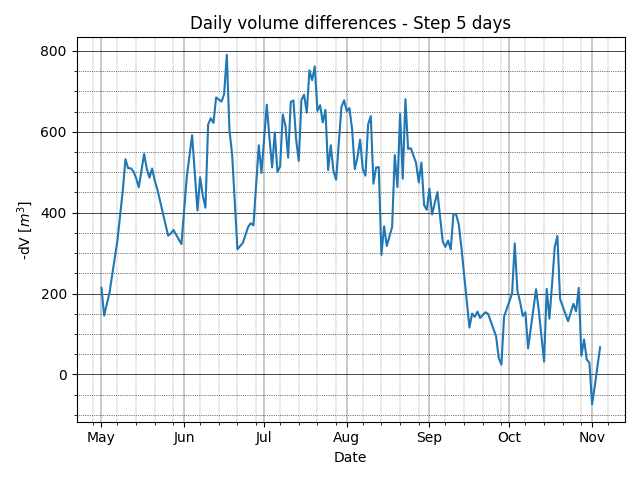

In [4]:
# Make plot for Daily volumes
fig, ax = plt.subplots()
fig.set_tight_layout(True)
ax.grid(visible=True, which="both")
ax.plot(df["date_in"], -df["volume_daily_normalized"])
ax.set_xlabel("Date")
ax.xaxis.set_major_formatter(dateFmt)
ax.set_ylabel("-dV [$m^3$]")
ax.set_title(f"Daily volume differences - Step {TSTEP} days")
ax.minorticks_on()
ax.grid(which="major", axis="y", linewidth=0.5, color="black")
ax.grid(which="major", axis="x", linewidth=0.3, color="black")
ax.grid(which="minor", axis="y", linestyle=":", linewidth=0.5, color="black")
ax.grid(which="minor", axis="x", linestyle=":", linewidth=0.3, color="black")
ax.xaxis.set_minor_locator(
    DayLocator(bymonthday=[7, 14, 21, 28], interval=1, tz=None)
)
# fig.set_size_inches(18.5, 10.5)
fig.savefig(out_dir / f"{fout_name}_daily_diff_norm.png", dpi=300)


In [15]:
# Dummy tests
date_range = [
    pd.to_datetime("2022-05-01"),
    pd.to_datetime("2022-09-21")

]
df_summer = df.loc[(df["date_in"] >= date_range[0]) & (df["date_in"] <= date_range[1])]
df_autumn = df.loc[(df["date_in"] > date_range[1])]

In [17]:
print(df["volume_daily_normalized"].mean())
print(df["volume_daily_normalized"].std())
print(df["volume_daily_normalized"].sum())

print(df_summer["volume_daily_normalized"].mean())
print(df_summer["volume_daily_normalized"].std())
print(df_summer["volume_daily_normalized"].sum())

print(df_autumn["volume_daily_normalized"].mean())
print(df_autumn["volume_daily_normalized"].std())
print(df_autumn["volume_daily_normalized"].sum())


-411.3906611117582
203.24641435623147
-62942.771150099004
-490.02532006379477
150.34872458319154
-58313.01308759158
-136.16935477963014
95.41121804734172
-4629.758062507425


#### Volume vs temperature


In [ ]:
# Create host and parasite subplots
fig, host = plt.subplots(figsize=(10, 6))
par1 = host.twinx()
par2 = host.twinx()

# Plot temperature in host subplot
p1, = host.plot(temp_df["day_plot"], temp_df["Tavg_5d"], label="Temperature", linewidth=1, linestyle = 'solid', color="tab:blue")
p4 = host.plot(temp_df["day_plot"], temp_df["Tavg_5d_rloess"], label="Temperature trend", linewidth=0.5, linestyle = 'dashed', color="tab:blue")
 
# Plot volume loss
p2, = par1.plot(df["day_plot"], -df["volume_daily_normalized"], label="Volume", linewidth=1, linestyle = 'solid', color="tab:red")
p5 =  par1.plot(df["day_plot"], -df["volume_daily_norm_rloess"], label="Volume trend", linewidth=0.5, linestyle = 'dashed', color="tab:red")

# Plot surface velocity
p3, = par2.plot(df["day_plot"], surf_df["V"], label="Velocity", linewidth=1, linestyle = 'solid',color="tab:green")
p6 = par2.plot(df["day_plot"], surf_df["Vsmooth"], label="velocity trend", linewidth=0.5, linestyle = 'dashed',color="tab:green")


# Set x and y labels
host.set_xlabel("Date", fontsize=12)
host.set_ylabel("Temperature [$^{\circ}$C]", fontsize=12, color="tab:blue")
par1.set_ylabel("Daily volume loss [$m^3/d$]", fontsize=12, color="tab:red")
par2.set_ylabel("Surface velocity [$m/d$]", fontsize=12, color="tab:green")

# Set x and y labels
host.set_xlabel("Date", fontsize=12)
host.set_ylabel("Temperature [$^{\circ}$C]", fontsize=12, color="tab:blue")
par1.set_ylabel("Daily volume loss [$m^3/d$]", fontsize=12, color="tab:red")
par2.set_ylabel("Surface Velocity [$m/d$]", fontsize=12, color="tab:green")

# Set x-axis date format
dateFmt = DateFormatter('%b')
host.xaxis.set_major_formatter(dateFmt)

# Set grid lines
host.grid(which="both", linestyle="--", alpha=0.5)
host.grid(which="major", axis="y", linewidth=0.5, color="black")
host.grid(which="major", axis="x", linewidth=0.5, color="black")
host.xaxis.set_minor_locator(DayLocator(bymonthday=[7, 14, 21, 28], interval=1, tz=None))
host.grid(which="minor", axis="y", linestyle=":", linewidth=0.5, color="black")
host.grid(which="minor", axis="x", linestyle=":", linewidth=0.5, color="black")

# Adjust the positioning and scale of the third y-axis
par2.spines["right"].set_position(("outward", 60))
par2.spines["right"].set_color("tab:green")
par2.yaxis.label.set_color("tab:green")
par2.tick_params(axis="y", colors="tab:green")
par2.spines["right"].set_visible(True)
par2.yaxis.label.set_visible(True)

# Update the legend to include the surface velocity plot
lines = [p1, p2, p3]
labels = [line.get_label() for line in lines]
host.legend(lines, labels, loc="upper left", fontsize=12)

# Set colors
host.tick_params(axis="y", labelcolor="tab:blue")
par1.tick_params(axis="y", labelcolor="tab:red")
host.yaxis.label.set_color("tab:blue")
par1.yaxis.label.set_color("tab:red")
par2.yaxis.label.set_color("tab:green")

# Set title
# plt.title(f"Temperature, Volume Loss, and Surface Velocity (step {TSTEP} days)", fontsize=14)
plt.tight_layout()
# fig.savefig(df_out_dir / f"{Path(SURF_VEL_FILE).stem}.png", dpi=300)


In [ ]:
# Make plot for Cumulated volumes
major_locator = mdates.MonthLocator(interval=1)
major_formatter = mdates.ConciseDateFormatter(major_locator)
minor_locator =  mdates.WeekdayLocator(byweekday=0, interval=1)

fig, ax = plt.subplots()
fig.set_tight_layout(True)
p1 = ax.plot(df["date_in"], -df["volume_daily_norm_cumul"], label="Cumulated volume loss", linewidth=2, color="tab:blue")
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("-dV [$m^3$]", fontsize=12)
ax.set_title(f"Cumulated volume loss - Step {TSTEP} days", fontsize=12)
ax.grid(True)
ax.minorticks_on()
ax.grid(which="major", axis="y", linewidth=0.5, color="black")
ax.grid(which="major", axis="x", linewidth=0.3, color="black")
ax.grid(which="minor", axis="y", linestyle=":", linewidth=0.5, color="black")
ax.grid(which="minor", axis="x", linestyle=":", linewidth=0.3, color="black")
ax.xaxis.set_major_locator(major_locator)
ax.xaxis.set_major_formatter(major_formatter)
ax.xaxis.set_minor_locator(minor_locator)

# Set legend
lines = p1
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, loc="upper left", fontsize=12)
plt.tight_layout()

# fig.set_size_inches(18.5, 10.5)
fig.savefig(out_dir / f"{fout_name}_daily_diff_norm_cumulated.png", dpi=300)

plt.show()



In [ ]:
# Plot only volume-temperatures

# Create host and parasite subplots
fig, host = plt.subplots(figsize=(10, 6))
par = host.twinx()

# Create temperature and volume plots
p1, = host.plot(temp_df["day_plot"], temp_df["Tavg_5d"], label="Temperature", linewidth=1, color="tab:blue")
p2, = par.plot(df["day_plot"], -df["volume_daily_normalized"], label="Volume", linewidth=1, color="tab:red")

# Set x and y labels
host.set_xlabel("Date", fontsize=12)
host.set_ylabel("Temperature [$^{\circ}$C]", fontsize=12, color="tab:blue")
par.set_ylabel("Daily volume loss [$m^3/d$]", fontsize=12, color="tab:red")

# Set x-axis date format
dateFmt = DateFormatter('%b')
host.xaxis.set_major_formatter(dateFmt)

# Set grid lines
host.grid(which="both", linestyle="--", alpha=0.5)
host.grid(which="major", axis="y", linewidth=0.5, color="black")
host.grid(which="major", axis="x", linewidth=0.5, color="black")
host.xaxis.set_minor_locator(DayLocator(bymonthday=[7, 14, 21, 28], interval=1, tz=None))
host.grid(which="minor", axis="y", linestyle=":", linewidth=0.5, color="black")
host.grid(which="minor", axis="x", linestyle=":", linewidth=0.5, color="black")

# Set legend
lines = [p1, p2]
labels = [line.get_label() for line in lines]
host.legend(lines, labels, loc="upper left", fontsize=12)

# Set colors
host.tick_params(axis="y", labelcolor="tab:blue")
par.tick_params(axis="y", labelcolor="tab:red")
host.yaxis.label.set_color("tab:blue")
par.yaxis.label.set_color("tab:red")

# Set title
plt.title(f"Temperature and Volume Loss (step {TSTEP} days)", fontsize=14)
plt.tight_layout()

plt.show()


In [ ]:
# OLD Test for rolling average
# df["day_plot"] = df["date_in"] + np.timedelta64(5, "D") 
# df["day_plot"] = df["date_in"]
# temp_df["day_plot"] = temp_df["data"]
# temp_df["Tmed_5d"] = temp_df["Tmed"] .rolling(5, min_periods=1, center=False).mean()


# Trying to manaully compute rolling average on the same time window as the volume (differs from a regular rolling average with fixed time window is almost negligible)

# merged = pd.merge(temp_df, df, left_on="data", right_on="date_in", how="left")
# merged = merged[["data", "Tmed", "date_in", "date_fin"]]

# merged['rol_avg'] = np.nan
# for i in range(len(merged["date_in"])):
#     if pd.isna(merged["date_in"][i]):
#         continue    
#     d_in = merged["date_in"][i]
#     d_fin = merged["date_fin"][i]
#     mask = (merged['data'] >= d_in) & (merged['data'] < d_fin)
#     avg = merged['Tmed'][mask].mean()
#     merged['rol_avg'][i]  = avg
 
# T_roll_avg = merged[["date_in", "date_fin", "rol_avg"]][merged["date_in"].notnull()]